# Phase 3: Optimal Data Augmentation, Regularizers, Finding the Best Model etc..

**In this notebook, I will take the most efficient model created from Phase 2, and attempt to improve upon the model´s performance with the Cifar-10 dataset.**


The goal of this notebook is to build upon the most effective model from **Phase 2**, focussing on:

- The number of epochs - Increasing to 500 and monitoring performance. 

- The Optimum Data Augmentation techniques from **Phase 2**

- Increasing the Number of Neurons in the Model

- Regularization & Best Model Callback

For more information, please go to https://www.cs.toronto.edu/~kriz/cifar.html

---

## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, regularizers
from keras.layers import Conv2D, Flatten

import time
starting_time = time.time()

## Read Data

**The following steps have been covered in *Phase 1* of the project. For more information on how the data was extracted and pre-processed, please refer to the Phase 1 notebook**

In [2]:
#define the unpickle function provided by the readme.html file with the data

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

## Pre-Processing
### Creating a Function, Unpickling and Preparing The Data

In [3]:
def preparecifar10(batches):
    _data = []
    _labels = []
    
    # Load and concatenate all batches
    for batch in batches:
        data = batch[b'data']
        labels = batch[b'labels']

        #put data in array format
        data = np.array(data, dtype=np.float32)
        labels = np.array(labels, dtype=np.int32)

        #reshape the data to combine RGB elements in one image
        images = data.reshape(-1, 3, 32, 32)
        images = np.swapaxes(images, 1, 3)

        #normalise the data to fit between 0 and 1, then rotate, then resize and rescale
        images = images / 255.0
        images = tf.image.rot90(images,3)
        _data.append(images)
        _labels.append(labels)
    
    # Convert lists to numpy arrays
    _data = np.concatenate(_data, axis=0)
    _labels = np.concatenate(_labels, axis=0)

    return _data, _labels


In [4]:
#unpickle train data
batches = [unpickle(f'data/cifar-10-batches-py/data_batch_{i}') for i in range(1, 6)]

#unpickle test data
tests = [unpickle(f'data/cifar-10-batches-py/test_batch')]

### Apply the function to prepare the data. 

In [5]:
train_images, train_labels = preparecifar10(batches)
test_images, test_labels = preparecifar10(tests)

## Metadata Unpickle

In [6]:
#load the metadata
metadata = unpickle('data/cifar-10-batches-py/batches.meta')

In [7]:
metadata[b'label_names']
clean = []
for i in metadata[b'label_names']:
    clean.append(str(i).split("'")[1])

In [8]:
#Create a dictionary with each label and number equivalent
labeldict = []
for i in range(len(np.unique(train_labels))):
    labeldict.append({np.unique(train_labels)[i]:metadata[b'label_names'][i]})
    

In [9]:
classnames = dict(zip(np.unique(train_labels),clean))

 ---

## Augmentation

**These techniques were explored in Phase 2. Please read the relevant notebook for more information:**

We will only be defining the following two augmentation methods:

- Random Zoom
- Random Flip


#### Apply Random Zoom To Images

In [10]:
random_zoom = tf.keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2)

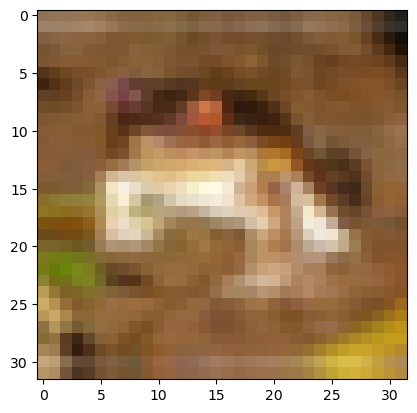

In [11]:
plt.imshow(random_zoom(train_images[0]));

#### Apply Random Flip to Images

In [12]:
random_flip = tf.keras.layers.RandomFlip(mode="horizontal_and_vertical")

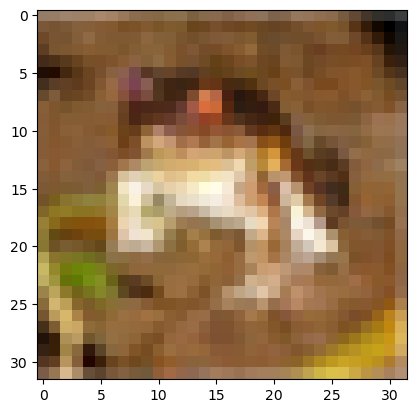

In [13]:
plt.imshow(random_flip(train_images[0]));

--- 

## Fit the model

### We will now fit some models and run some tests on the most effective augmentation techniques

We will be working with the parameters from the most accurate model from **Phase 2**:

---
- #### Model 1 - Random Zoom & Random Flip
      This model consists of Random Zoom and Random Flip augmentation methods, fed into a Convolutional Neural Network (CNN) of 3 Hidden Layers, Max Pooling over 500 epochs. This tests whether the model continues to incrementally improve, or begins to overfit.

---
- #### Model 2 - Restructuring the Convolutional Layers' Neurons.
      This will involve broadening Convolutional layers to be implemented of Model 1's architecture over 500 epochs to measure whether the model's performance is affected by layers.
   
---
- #### Model 3 - Testing L2 (Ridge) Regularization.
      This will be implemented on Model 1's architecture over 500 epochs to measure its effect on overfitting and impact on the results.

--- 
- #### Model 4 - Testing L1 (Lasso) Regularization.
      This will be implemented on Model 1's architecture over 500 epochs to measure its effect on overfitting and impact on the results.
---

- #### Model 5 - Adding Dropout to Model 2.
      This will introduce dropout to Model 2 to see if it promotes performance. Dropout will be tuned to 0.1 and 0.2 to not penalise the model too harshly.

--- 

      The following two models are the result of the past 3 notebooks, and will be compared to see which are the most accurate when identifying objects in the images.

- #### Model2Best - Model 2 with Best Model Callback
      This will use the best model callback function to be able to reference the optimum epoch with the highest validation accuracy and lowest validation loss.


- #### Model5Best - Model 5 with Best Model Callback
      This will use the best model callback function to be able to reference the optimum epoch with the highest validation accuracy and lowest validation loss.

### Train / Validation Split

**Firstly we will split training data into training and validation sets, setting random state to ensure consistency in data**

In [14]:
training_images, validation_images, training_labels, validation_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

---

## Model 1 - Random Zoom & Random Flip

In [15]:
model1 = tf.keras.Sequential([random_zoom, random_flip])

model1.add(tf.keras.layers.Conv2D(32, (3,3), input_shape=(32,32,3), activation='relu'))
model1.add(tf.keras.layers.MaxPooling2D())

model1.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu'))
model1.add(tf.keras.layers.MaxPooling2D())

model1.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
model1.add(tf.keras.layers.MaxPooling2D())

model1.add(tf.keras.layers.Flatten())
model1.add(tf.keras.layers.Dense(128, activation='relu'))
model1.add(tf.keras.layers.Dense(10, activation='softmax'))

model1.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

model1_history = model1.fit(
    training_images,
    training_labels, 
    batch_size=32, 
    epochs=500, 
    validation_data=(validation_images, validation_labels))



/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/500


/opt/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:602: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 27s 21ms/step - accuracy: 0.2665 - loss: 1.9558 - val_accuracy: 0.4375 - val_loss: 1.5318
Epoch 2/500
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - accuracy: 0.4303 - loss: 1.5662 - val_accuracy: 0.4362 - val_loss: 1.5578
Epoch 3/500
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.4874 - loss: 1.4338 - val_accuracy: 0.4999 - val_loss: 1.4177
Epoch 4/500
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.5122 - loss: 1.3560 - val_accuracy: 0.5373 - val_loss: 1.2884
Epoch 5/500
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.5343 - loss: 1.2989 - val_accuracy: 0.5463 - val_loss: 1.2687
Epoch 6/500
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.5538 - loss: 1.2484 - val_accuracy: 0.5744 - val_loss: 1.1958
Epoch 7/500
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.5724 - loss: 1.2038 - val_accuracy: 0.5633 - val_loss: 1.2388
Epoch 8/500
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.5817 - los

**The model does not seem to overtrain, and after 250 epochs, the accuracy and loss metrics continue to improve. This could be something to revisit, should this be the most effective model**


In [16]:
ending_time =time.time()
training_time= ending_time - starting_time
print('Training took  ', training_time, ' seconds')

Training took   10996.80959391594  seconds


In [17]:
test_loss, test_acc = model1.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 1s - 3ms/step - accuracy: 0.7236 - loss: 0.8415

Test accuracy: 0.7235999703407288


**The model performs very well on the test set. 71% accuracy is a good score, and has added over 5% accuracy to our model. There is, however, still room for improvement, and we will add some more Data Augmentation methods to the data for model 2**

In [18]:
probability_model1 = tf.keras.Sequential([model1, 
                                         tf.keras.layers.Softmax()])

In [19]:
predictions1 = probability_model1.predict(test_images)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


**The following two functions were provided in the curriculum to be able to plot the predicted images with their predicted labels and true ones**

In [20]:
#this function was provided in the 
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(clean[predicted_label],
                                100*np.max(predictions_array),
                                clean[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

**View model performance on one instance**

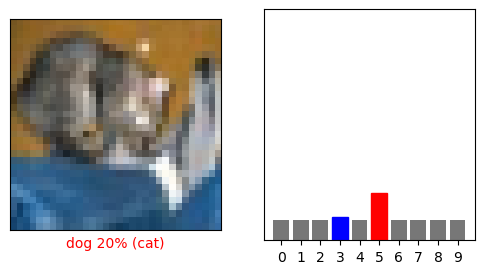

In [21]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions1[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions1[i],  test_labels)
plt.show()

**The model has inaccurately predicted a dog, rather than a cat, which appears in the image. The distribution, however is not as promising as one would like with this example. We will check a larger array of the images to see if the precision and accuracy is higher.**

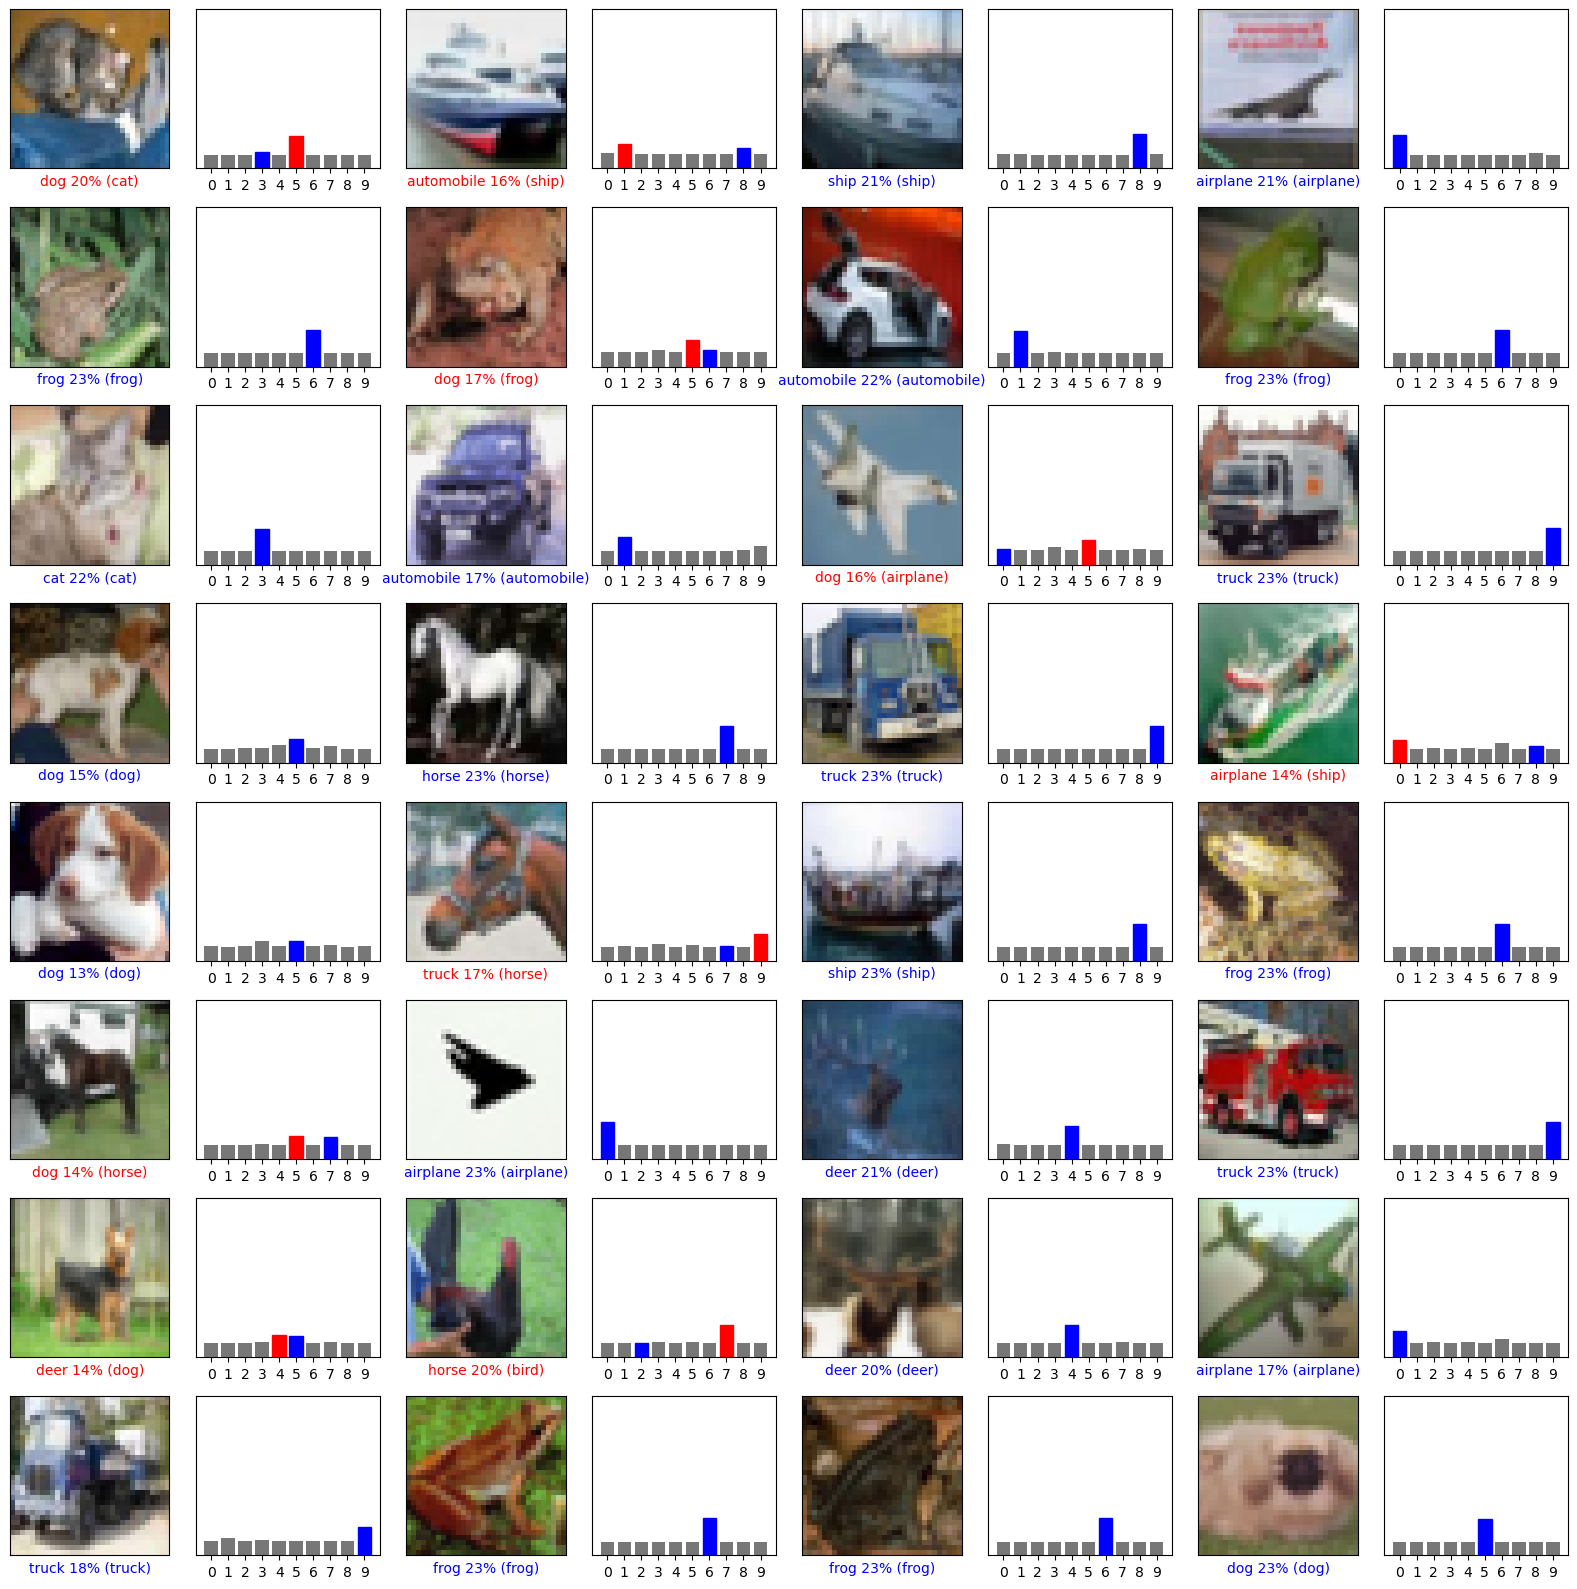

In [22]:
num_rows = 8
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions1[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions1[i], test_labels)
plt.tight_layout()
plt.show()

**The model is predicting much more accurately, we can see that when it makes a decision on the probability of the object contained within the image, it is predicting much more precisely, except for certain instances (deer & dog, bird & horse)**

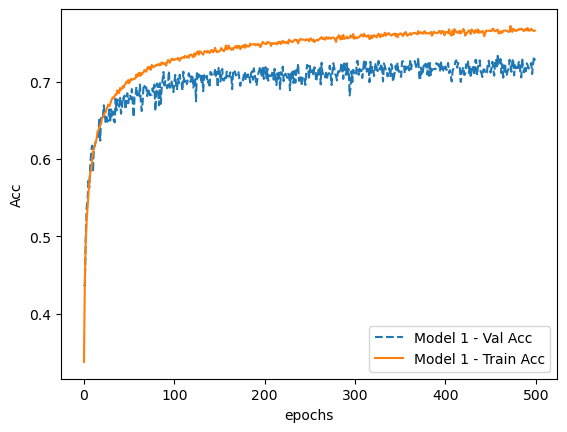

In [23]:
plt.plot(model1_history.history['val_accuracy'], '--', label="Model 1 - Val Acc")
plt.plot(model1_history.history['accuracy'], label="Model 1 - Train Acc")

plt.ylabel('Acc')
plt.xlabel('epochs')
plt.legend();

**We can see that this model does not easily overfit, suggesting that the pooling promotes robustness, while the number of epochs can steadily improve performance.**

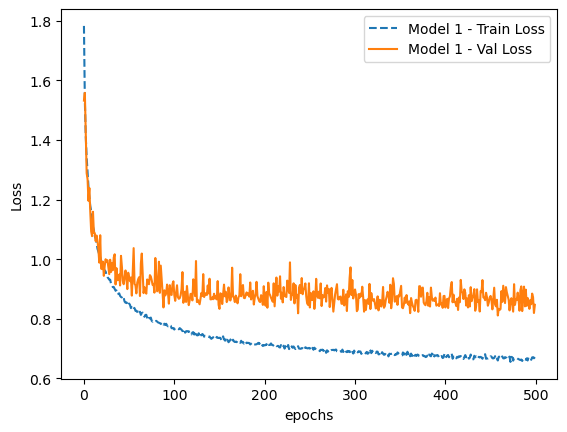

In [24]:
plt.plot(model1_history.history['loss'], '--', label="Model 1 - Train Loss")
plt.plot(model1_history.history['val_loss'], label="Model 1 - Val Loss")

plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend();

**The Loss metric on the validation set seems to be reaching its optimal level, but not overfitting. Once the optimal augmentation approach is found, we will see if it is the same. In which case, we may push for a higher number of epochs with early stopping** 

---

## Model 2 - Restructuring the Convolutional Layers' Neurons.

In [25]:
model2 = tf.keras.Sequential([random_zoom, random_flip])

model2.add(tf.keras.layers.Conv2D(32, (3,3), input_shape=(32,32,3), activation='relu'))
model2.add(tf.keras.layers.MaxPooling2D())

#double neurons
model2.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
model2.add(tf.keras.layers.MaxPooling2D())

#double again
model2.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu'))
model2.add(tf.keras.layers.MaxPooling2D())

#double again
model2.add(tf.keras.layers.Flatten())
model2.add(tf.keras.layers.Dense(256, activation='relu'))
model2.add(tf.keras.layers.Dense(10, activation='softmax'))

model2.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

model2_history = model2.fit(
    training_images,
    training_labels, 
    batch_size=32, 
    epochs=500, 
    validation_data=(validation_images, validation_labels))



Epoch 1/500
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.2719 - loss: 1.9351 - val_accuracy: 0.4206 - val_loss: 1.5606
Epoch 2/500
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.4752 - loss: 1.4465 - val_accuracy: 0.5197 - val_loss: 1.3285
Epoch 3/500
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.5325 - loss: 1.3023 - val_accuracy: 0.5473 - val_loss: 1.2983
Epoch 4/500
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5709 - loss: 1.2077 - val_accuracy: 0.5838 - val_loss: 1.1663
Epoch 5/500
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.6043 - loss: 1.1255 - val_accuracy: 0.6146 - val_loss: 1.0948
Epoch 6/500
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.6119 - loss: 1.0926 - val_accuracy: 0.6210 - val_loss: 1.0686
Epoch 7/500
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - accuracy: 0.6332 - loss: 1.0405 - val_accuracy: 0.6257 - val_loss: 1.0709
Epoch 8/500
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 

**The model does not seem to overtrain, and after 250 epochs, the accuracy and loss metrics continue to improve. This could be something to revisit, should this be the most effective model**


In [26]:
ending_time =time.time()
training_time= ending_time - starting_time
print('Training took  ', training_time, ' seconds')

Training took   25542.495016098022  seconds


In [61]:
test_loss, test_acc = model2.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 2s - 7ms/step - accuracy: 0.7373 - loss: 1.0712

Test accuracy: 0.7372999787330627


**The model performs very well on the test set. 71% accuracy is a good score, and has added over 5% accuracy to our model. There is, however, still room for improvement, and we will add some more Data Augmentation methods to the data for model 2**

In [28]:
probability_model2 = tf.keras.Sequential([model2, 
                                         tf.keras.layers.Softmax()])

In [29]:
predictions2 = probability_model2.predict(test_images)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


**View model performance on one instance**

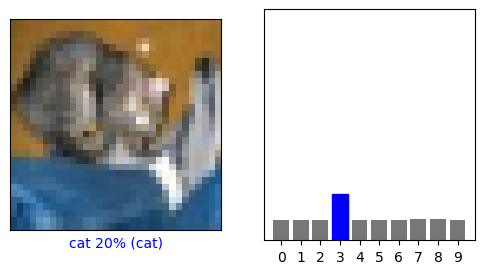

In [30]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions2[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions2[i],  test_labels)
plt.show()

**The model has accurately predicted the a cat appears in the image. The distribution, however is still not as promising as one would like with this example. We will check a larger array of the images to see if the precision is higher.**

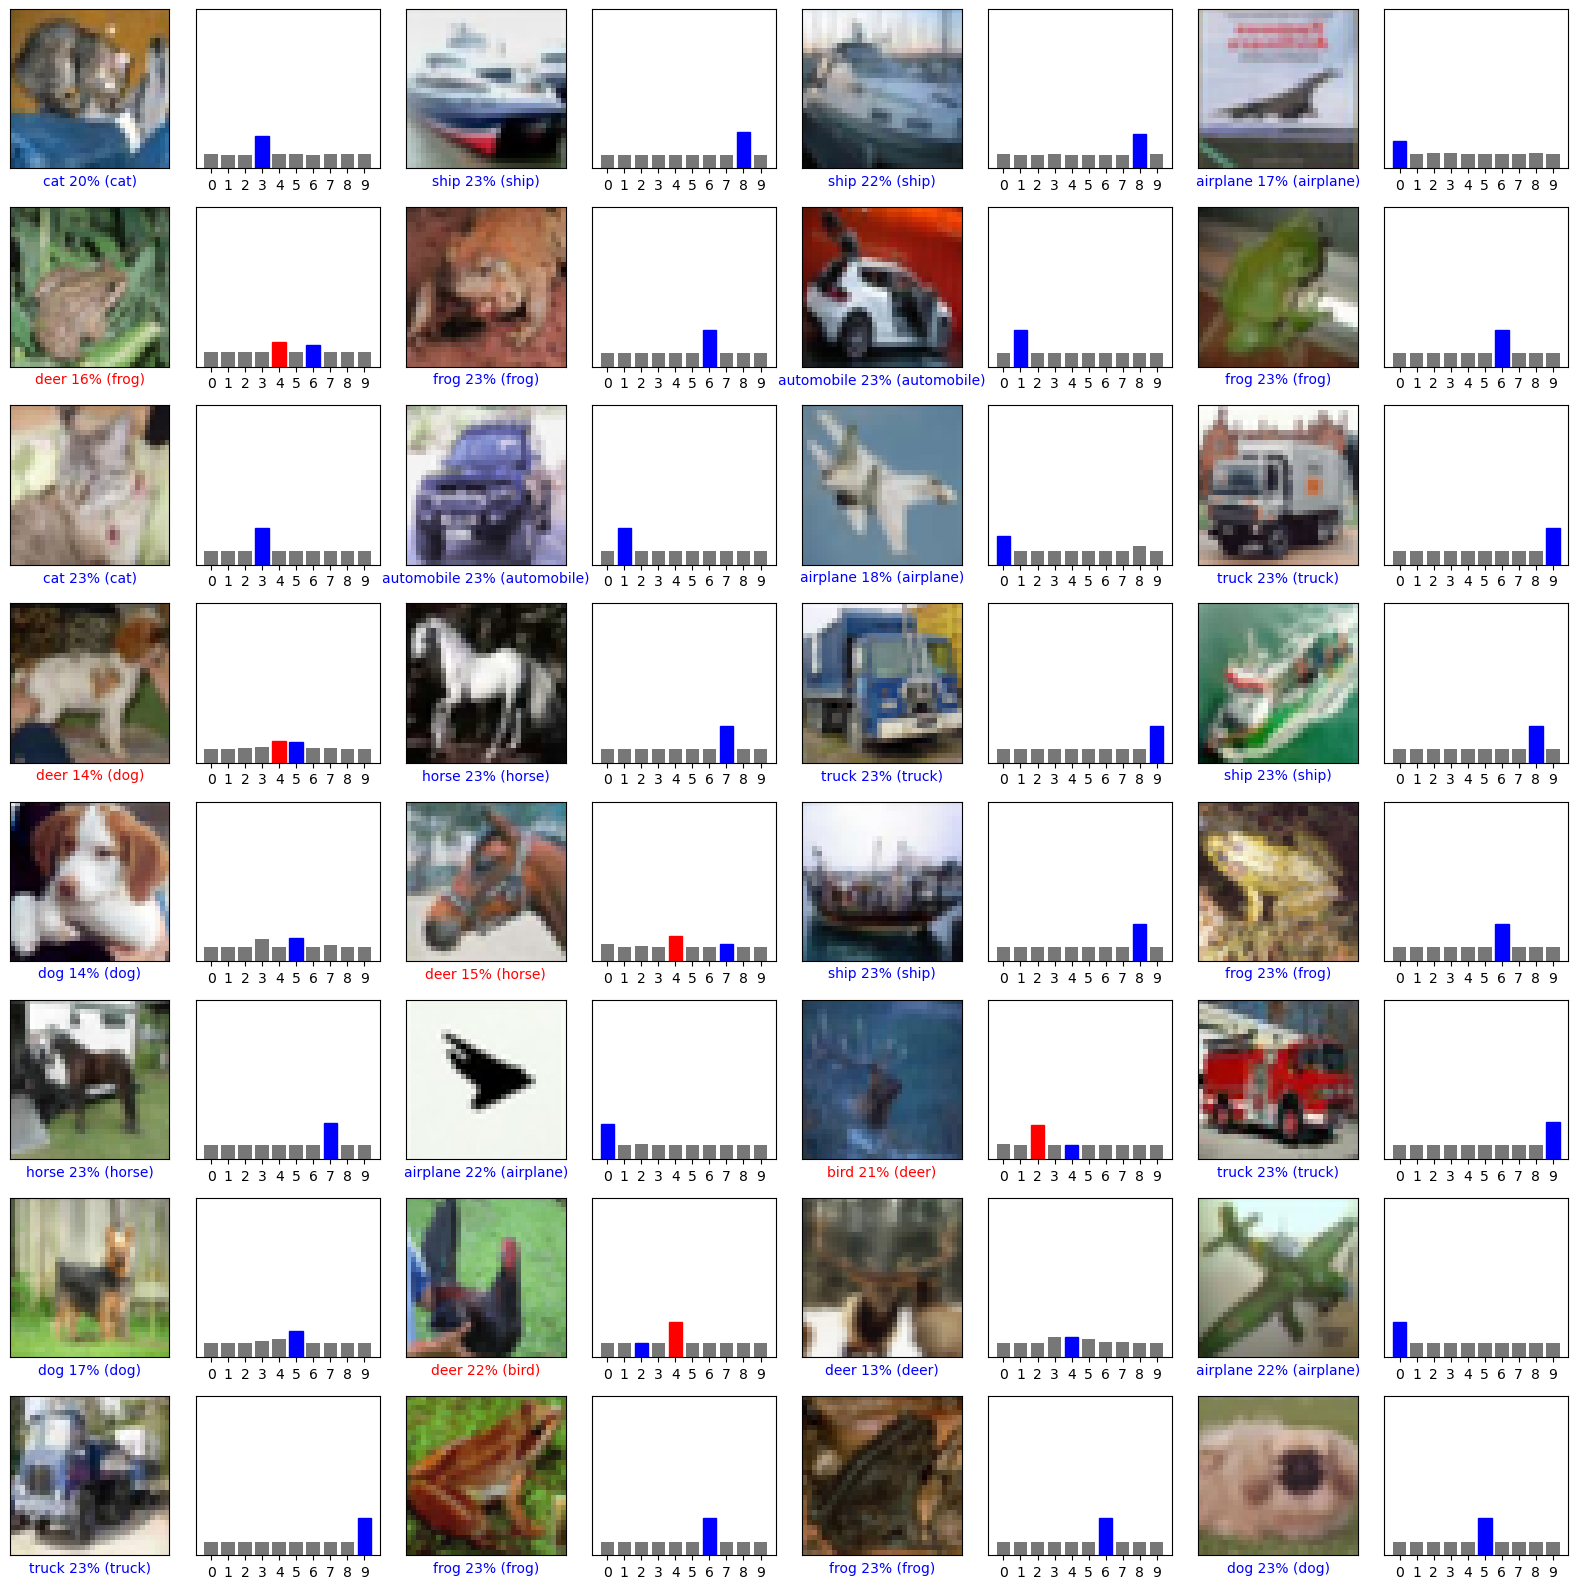

In [31]:
num_rows = 8
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions2[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions2[i], test_labels)
plt.tight_layout()
plt.show()

**The model is predicting much more accurately, we can see that when it makes a decision on the probability of the object contained within the image, it is predicting much more precisely, except for certain instances (deer & dog, bird & horse)**

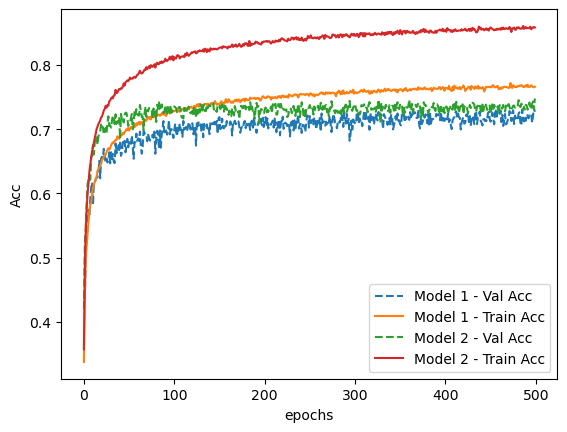

In [32]:
plt.plot(model1_history.history['val_accuracy'], '--', label="Model 1 - Val Acc")
plt.plot(model1_history.history['accuracy'], label="Model 1 - Train Acc")

plt.plot(model2_history.history['val_accuracy'], '--', label="Model 2 - Val Acc")
plt.plot(model2_history.history['accuracy'], label="Model 2 - Train Acc")

plt.ylabel('Acc')
plt.xlabel('epochs')
plt.legend();

**We can see that this model does not easily overfit, suggesting that the pooling promotes robustness, while the number of epochs can steadily improve performance.**

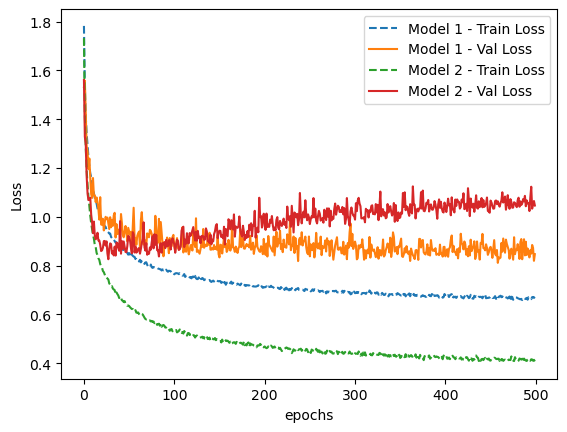

In [152]:
plt.plot(model1_history.history['loss'], '--', label="Model 1 - Train Loss")
plt.plot(model1_history.history['val_loss'], label="Model 1 - Val Loss")

plt.plot(model2_history.history['loss'], '--', label="Model 2 - Train Loss")
plt.plot(model2_history.history['val_loss'], label="Model 2 - Val Loss")

plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend();

**The Loss metric on the validation set seems to be reaching its optimal level, whereas model 2's loss seems to substantially increase after a low number of epochs. Once the optimal augmentation approach is found, we will see if it is the same. In which case, we may push for a higher number of epochs with early stopping** 

---

# Regularization

## Model 3 - Testing L2 (Ridge) Regularization

In [34]:
model3 = tf.keras.Sequential([random_zoom, random_flip])

model3.add(tf.keras.layers.Conv2D(32, (3,3), input_shape=(32,32,3), activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model3.add(tf.keras.layers.MaxPooling2D())
model3.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
model3.add(tf.keras.layers.MaxPooling2D())
model3.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu'))
model3.add(tf.keras.layers.MaxPooling2D())
model3.add(tf.keras.layers.Flatten())
model3.add(tf.keras.layers.Dense(256, activation='relu'))
model3.add(tf.keras.layers.Dense(10, activation='softmax'))

model3.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

model3_history = model3.fit(
    training_images,
    training_labels, 
    batch_size=32, 
    epochs=500, 
    validation_data=(validation_images, validation_labels))

Epoch 1/500
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 44s 34ms/step - accuracy: 0.2567 - loss: 2.0023 - val_accuracy: 0.4231 - val_loss: 1.5888
Epoch 2/500
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 38s 31ms/step - accuracy: 0.4383 - loss: 1.5660 - val_accuracy: 0.5073 - val_loss: 1.3974
Epoch 3/500
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 36s 29ms/step - accuracy: 0.4908 - loss: 1.4322 - val_accuracy: 0.5352 - val_loss: 1.3035
Epoch 4/500
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 39s 31ms/step - accuracy: 0.5339 - loss: 1.3382 - val_accuracy: 0.5589 - val_loss: 1.2671
Epoch 5/500
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.5539 - loss: 1.2725 - val_accuracy: 0.5925 - val_loss: 1.1758
Epoch 6/500
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 38s 30ms/step - accuracy: 0.5756 - loss: 1.2214 - val_accuracy: 0.5764 - val_loss: 1.2270
Epoch 7/500
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 42s 33ms/step - accuracy: 0.5931 - loss: 1.1806 - val_accuracy: 0.6116 - val_loss: 1.1233
Epoch 8/500
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 

## Model 4 - Testing L1 (Lasso) Regularization

In [35]:
model4 = tf.keras.Sequential([random_zoom, random_flip])

model4.add(tf.keras.layers.Conv2D(32, (3,3), input_shape=(32,32,3), activation='relu',kernel_regularizer=regularizers.l1(0.01)))
model4.add(tf.keras.layers.MaxPooling2D())
model4.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
model4.add(tf.keras.layers.MaxPooling2D())
model4.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu'))
model4.add(tf.keras.layers.MaxPooling2D())
model4.add(tf.keras.layers.Flatten())
model4.add(tf.keras.layers.Dense(256, activation='relu'))
model4.add(tf.keras.layers.Dense(10, activation='softmax'))

model4.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

model4_history = model4.fit(
    training_images,
    training_labels, 
    batch_size=32, 
    epochs=500, 
    validation_data=(validation_images, validation_labels))

Epoch 1/500
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.2610 - loss: 2.1409 - val_accuracy: 0.4308 - val_loss: 1.6232
Epoch 2/500
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.4343 - loss: 1.6261 - val_accuracy: 0.4831 - val_loss: 1.4942
Epoch 3/500
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.4865 - loss: 1.4968 - val_accuracy: 0.5231 - val_loss: 1.3995
Epoch 4/500
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.5149 - loss: 1.4163 - val_accuracy: 0.5564 - val_loss: 1.3235
Epoch 5/500
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.5466 - loss: 1.3493 - val_accuracy: 0.5751 - val_loss: 1.2688
Epoch 6/500
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.5690 - loss: 1.2984 - val_accuracy: 0.5671 - val_loss: 1.2641
Epoch 7/500
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.5797 - loss: 1.2656 - val_accuracy: 0.5786 - val_loss: 1.2585
Epoch 8/500
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 

### Results

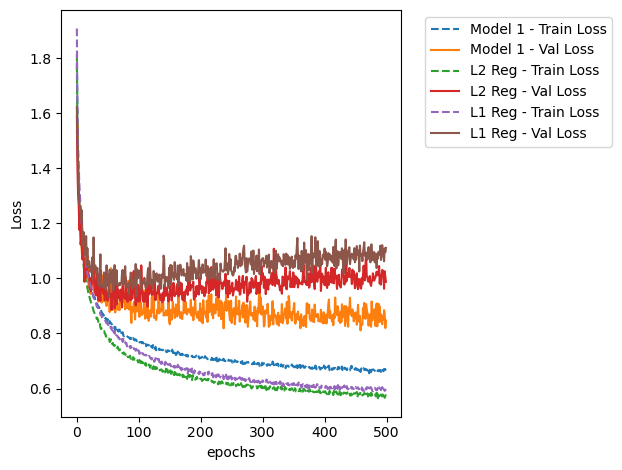

In [36]:
plt.plot(model1_history.history['loss'], '--', label="Model 1 - Train Loss")
plt.plot(model1_history.history['val_loss'], label="Model 1 - Val Loss")

plt.plot(model3_history.history['loss'], '--', label="L2 Reg - Train Loss")
plt.plot(model3_history.history['val_loss'], label="L2 Reg - Val Loss")

plt.plot(model4_history.history['loss'], '--', label="L1 Reg - Train Loss")
plt.plot(model4_history.history['val_loss'], label="L1 Reg - Val Loss")

plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.show()

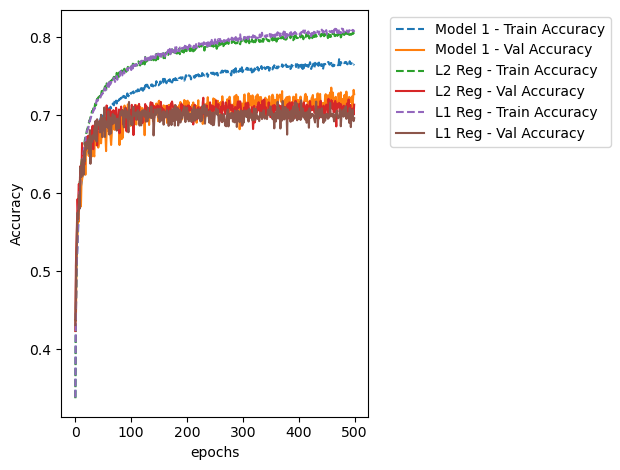

In [37]:
plt.plot(model1_history.history['accuracy'], '--', label="Model 1 - Train Accuracy")
plt.plot(model1_history.history['val_accuracy'], label="Model 1 - Val Accuracy")

plt.plot(model3_history.history['accuracy'], '--', label="L2 Reg - Train Accuracy")
plt.plot(model3_history.history['val_accuracy'], label="L2 Reg - Val Accuracy")

plt.plot(model4_history.history['accuracy'], '--', label="L1 Reg - Train Accuracy")
plt.plot(model4_history.history['val_accuracy'], label="L1 Reg - Val Accuracy")

plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.show()



**Comparison of the Models with regards to loss and accuracy show that L2 (Ridge) Regularization would be the preferred approach, should reguarlization be necessary. The model perform extremely well without, and does not seem prone to overfitting. This could be due to pooling, which can effectively mitigate any overtraining**

## Model 5 - Adding Dropout

**I will apply dropout to see if it is able to improve performance higher than 72% on test data.**

In [38]:
model5 = tf.keras.Sequential([random_zoom, random_flip])

model5.add(tf.keras.layers.Conv2D(32, (3,3), input_shape=(32,32,3), activation='relu'))
model5.add(tf.keras.layers.Dropout(0.1))
model5.add(tf.keras.layers.MaxPooling2D())
model5.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
model5.add(tf.keras.layers.Dropout(0.1))
model5.add(tf.keras.layers.MaxPooling2D())
model5.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu'))
model5.add(tf.keras.layers.Dropout(0.2))
model5.add(tf.keras.layers.MaxPooling2D())
model5.add(tf.keras.layers.Flatten())
model5.add(tf.keras.layers.Dense(256, activation='relu'))
model5.add(tf.keras.layers.Dropout(0.1))
model5.add(tf.keras.layers.Dense(10, activation='softmax'))

model5.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

model5_history = model5.fit(
    training_images,
    training_labels, 
    batch_size=32, 
    epochs=500, 
    validation_data=(validation_images, validation_labels))






Epoch 1/500
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - accuracy: 0.2862 - loss: 1.9042 - val_accuracy: 0.4687 - val_loss: 1.5242
Epoch 2/500
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - accuracy: 0.4585 - loss: 1.4991 - val_accuracy: 0.5276 - val_loss: 1.3394
Epoch 3/500
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - accuracy: 0.5123 - loss: 1.3546 - val_accuracy: 0.5691 - val_loss: 1.2312
Epoch 4/500
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.5533 - loss: 1.2503 - val_accuracy: 0.5835 - val_loss: 1.2031
Epoch 5/500
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.5731 - loss: 1.2060 - val_accuracy: 0.6035 - val_loss: 1.1224
Epoch 6/500
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.5965 - loss: 1.1440 - val_accuracy: 0.6175 - val_loss: 1.0987
Epoch 7/500
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.6001 - loss: 1.1253 - val_accuracy: 0.6432 - val_loss: 1.0214
Epoch 8/500
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 

In [39]:
ending_time =time.time()
training_time= ending_time - starting_time
print('Training took  ', training_time, ' seconds')

Training took   63385.598710775375  seconds


In [40]:
test_loss, test_acc = model5.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 1s - 5ms/step - accuracy: 0.7617 - loss: 0.7165

Test accuracy: 0.7616999745368958


**The model performs extremely well compared to any other models. 76% accuracy is a much better score, suggesting that Dropout is indeed helping the model to perform much better**

In [41]:
probability_model5 = tf.keras.Sequential([model5, 
                                         tf.keras.layers.Softmax()])

In [42]:
predictions5 = probability_model5.predict(test_images)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


**View model performance on one instance**

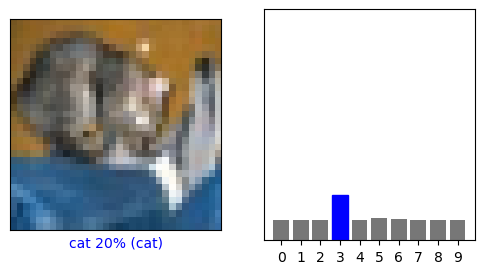

In [43]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions5[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions5[i],  test_labels)
plt.show()

**The model has accurately predicted the a cat appears in the image. The distribution, however is still not as promising as one would like with this example. We will check a larger array of the images to see if the precision is higher.**

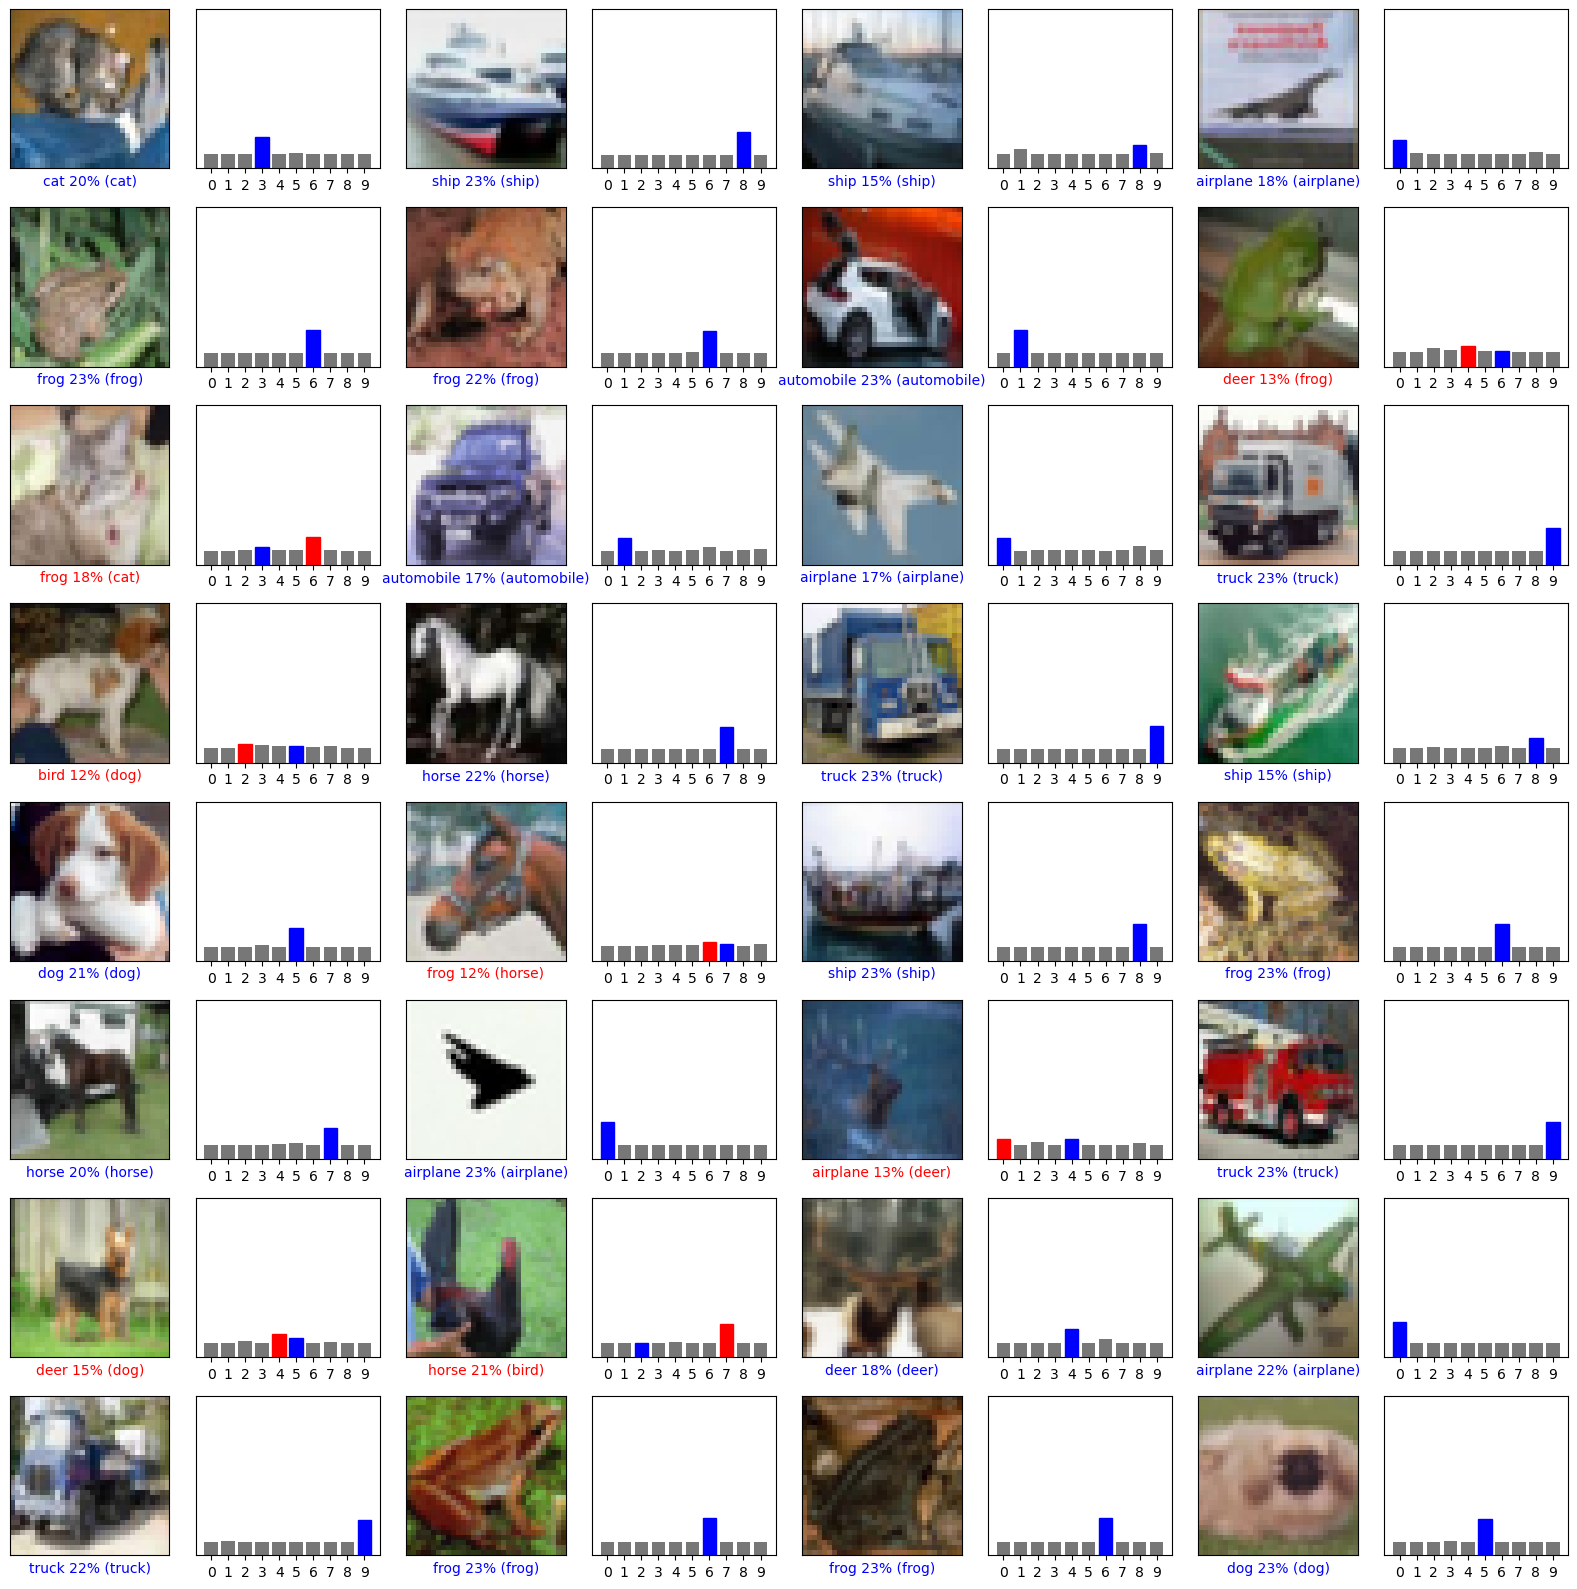

In [44]:
num_rows = 8
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions5[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions5[i], test_labels)
plt.tight_layout()
plt.show()

**The model is predicting much more accurately, we can see that when it makes a decision on the probability of the object contained within the image, it is predicting much more precisely.**

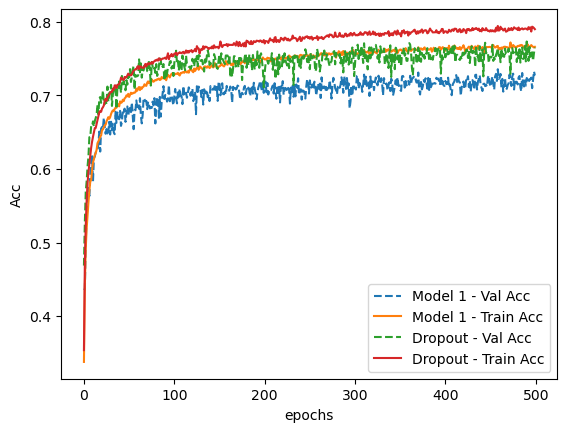

In [45]:
plt.plot(model1_history.history['val_accuracy'], '--', label="Model 1 - Val Acc")
plt.plot(model1_history.history['accuracy'], label="Model 1 - Train Acc")

plt.plot(model5_history.history['val_accuracy'], '--', label="Dropout - Val Acc")
plt.plot(model5_history.history['accuracy'], label="Dropout - Train Acc")

plt.ylabel('Acc')
plt.xlabel('epochs')
plt.legend();

**We can see that this model performs almost as well with the validation set as Model 1 is able to train, suggesting that Dropout is extremely good at optimising the model's performance.**

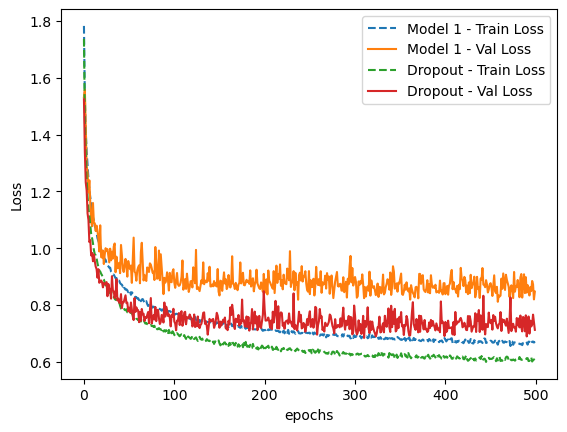

In [46]:
plt.plot(model1_history.history['loss'], '--', label="Model 1 - Train Loss")
plt.plot(model1_history.history['val_loss'], label="Model 1 - Val Loss")

plt.plot(model5_history.history['loss'], '--', label="Dropout - Train Loss")
plt.plot(model5_history.history['val_loss'], label="Dropout - Val Loss")

plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend();

**Once again, the Loss metric on the validation set seems to be reaching its optimal level with Dropout. It almost outperforms that of the training loss of model 1, which is quite impressive** 

---

# Finding the best model

## Model1Best - Model 1 with Best Model Callback

In [47]:
model1best = tf.keras.Sequential([random_zoom, random_flip])

model1best.add(tf.keras.layers.Conv2D(32, (3,3), input_shape=(32,32,3), activation='relu'))
model1best.add(tf.keras.layers.MaxPooling2D())
model1best.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu'))
model1best.add(tf.keras.layers.MaxPooling2D())
model1best.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
model1best.add(tf.keras.layers.MaxPooling2D())
model1best.add(tf.keras.layers.Flatten())
model1best.add(tf.keras.layers.Dense(128, activation='relu'))
model1best.add(tf.keras.layers.Dense(10, activation='softmax'))

model1best.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])


model1best_history = model1best.fit(
    training_images,
    training_labels, 
    batch_size=32, 
    epochs=500, 
    validation_data=(validation_images, validation_labels),
    callbacks=[tf.keras.callbacks.ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)])

Epoch 1/500
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.2611 - loss: 1.9655 - val_accuracy: 0.4242 - val_loss: 1.5672
Epoch 2/500
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.4375 - loss: 1.5540 - val_accuracy: 0.4990 - val_loss: 1.3803
Epoch 3/500
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.4876 - loss: 1.4249 - val_accuracy: 0.5313 - val_loss: 1.3082
Epoch 4/500
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.5109 - loss: 1.3613 - val_accuracy: 0.5472 - val_loss: 1.2612
Epoch 5/500
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.5385 - loss: 1.2853 - val_accuracy: 0.5679 - val_loss: 1.2233
Epoch 6/500
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.5500 - loss: 1.2514 - val_accuracy: 0.5596 - val_loss: 1.2308
Epoch 7/500
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.5677 - loss: 1.2030 - val_accuracy: 0.5796 - val_loss: 1.2080
Epoch 8/500
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 

In [48]:
ending_time =time.time()
training_time= ending_time - starting_time
print('Training took  ', training_time, ' seconds')

Training took   73275.8222360611  seconds


In [49]:
test_loss, test_acc = model1best.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 2s - 5ms/step - accuracy: 0.7006 - loss: 0.9401

Test accuracy: 0.7006000280380249


In [50]:
probability_model1best = tf.keras.Sequential([model1best, 
                                         tf.keras.layers.Softmax()])

In [51]:
predictions1best = probability_model1best.predict(test_images)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


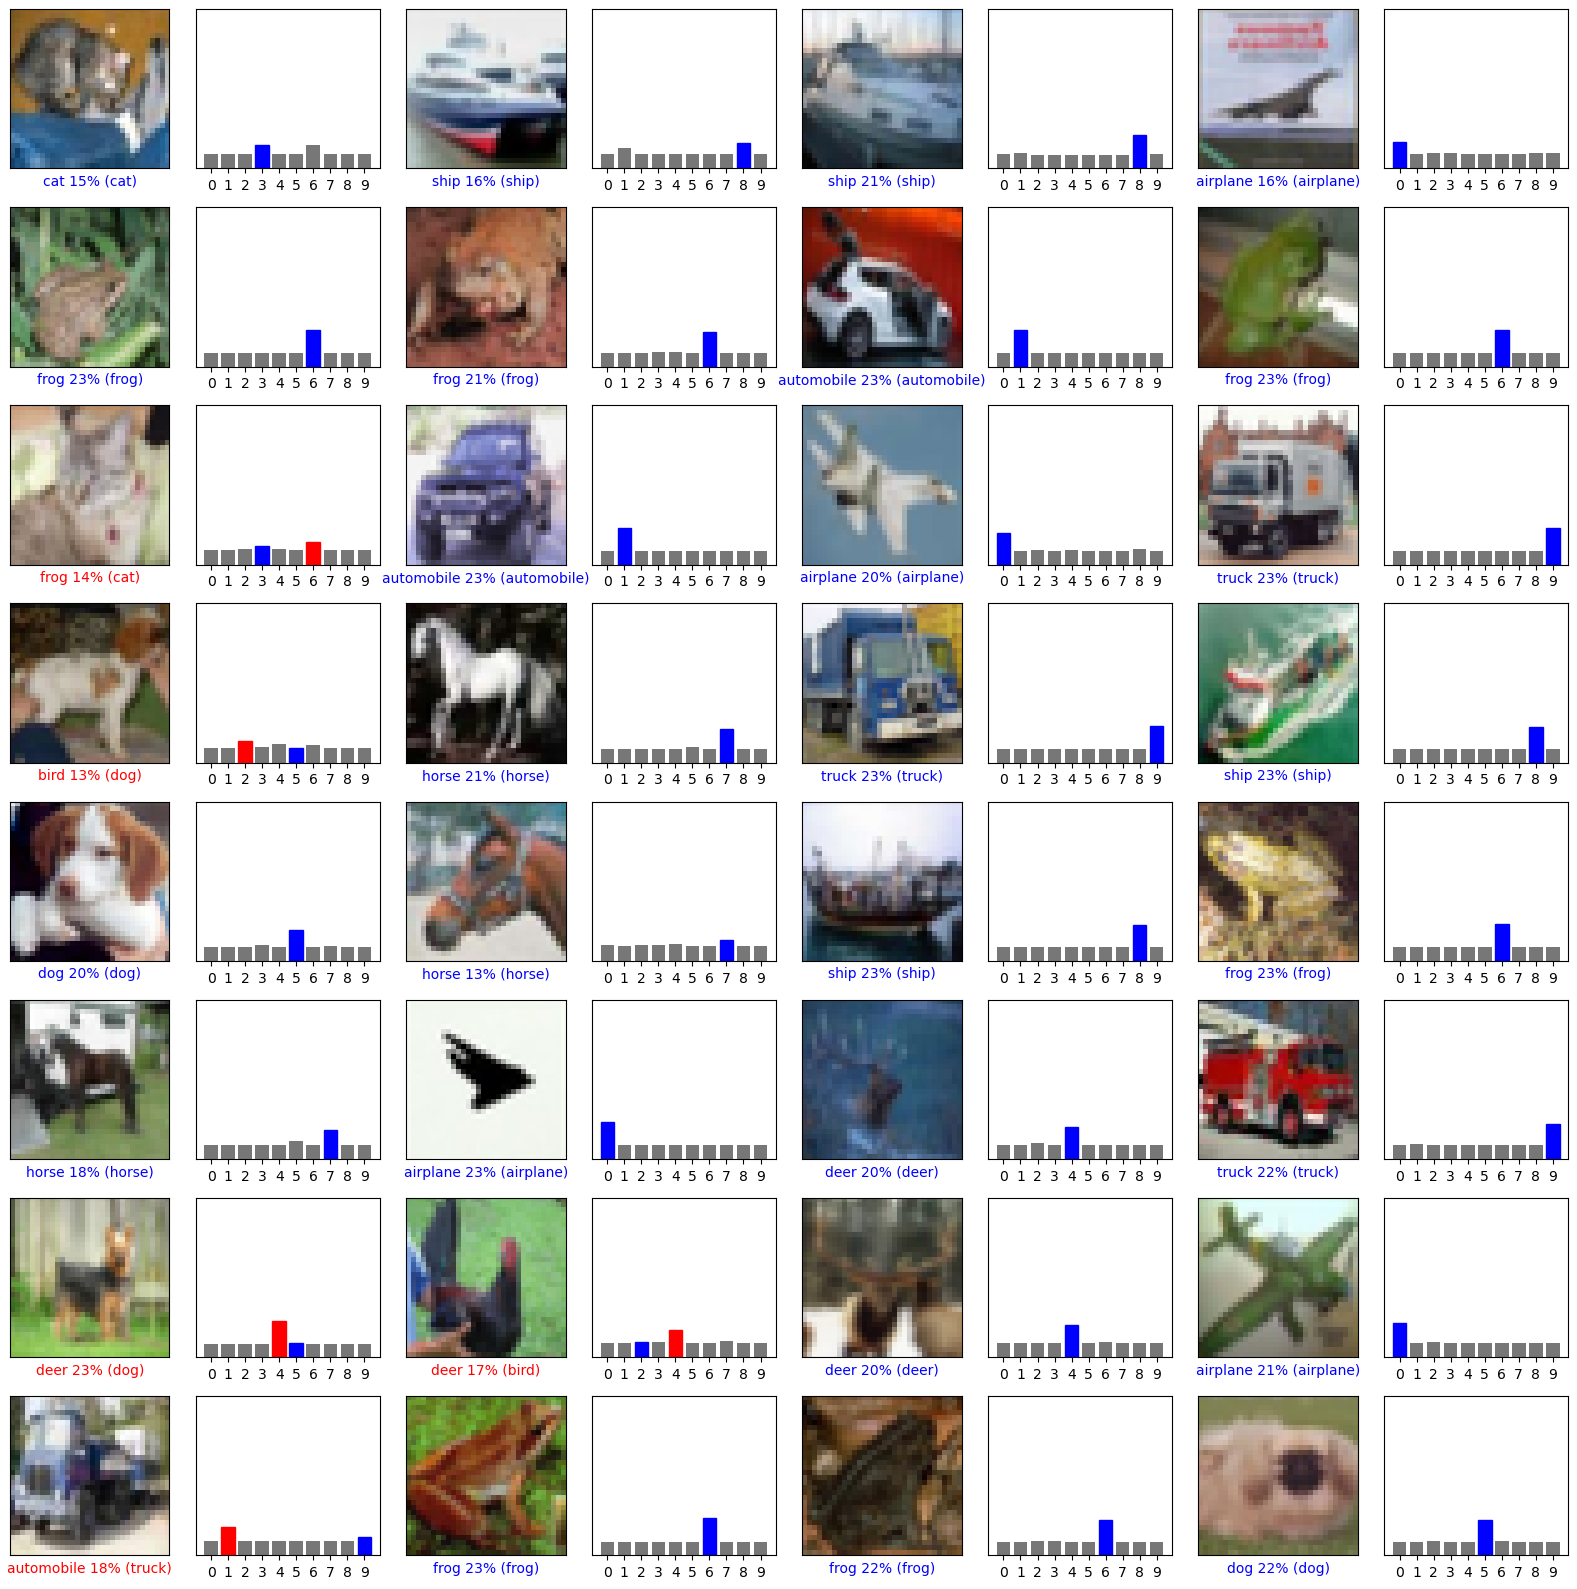

In [52]:
num_rows = 8
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions1best[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions1best[i], test_labels)
plt.tight_layout()
plt.show()

## Model5Best - Model 5 with Best Model Callback

In [ ]:
model5best = tf.keras.Sequential([random_zoom, random_flip])

model5best.add(tf.keras.layers.Conv2D(32, (3,3), input_shape=(32,32,3), activation='relu'))
model5best.add(tf.keras.layers.Dropout(0.1))
model5best.add(tf.keras.layers.MaxPooling2D())
model5best.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
model5best.add(tf.keras.layers.Dropout(0.1))
model5best.add(tf.keras.layers.MaxPooling2D())
model5best.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu'))
model5best.add(tf.keras.layers.Dropout(0.2))
model5best.add(tf.keras.layers.MaxPooling2D())
model5best.add(tf.keras.layers.Flatten())
model5best.add(tf.keras.layers.Dense(256, activation='relu'))
model5best.add(tf.keras.layers.Dropout(0.1))
model5best.add(tf.keras.layers.Dense(10, activation='softmax'))

model5best.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])


model5best_history = model5best.fit(
    training_images,
    training_labels, 
    batch_size=32, 
    epochs=500, 
    validation_data=(validation_images, validation_labels),
    callbacks=[tf.keras.callbacks.ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)])


Epoch 1/500
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.2880 - loss: 1.9099 - val_accuracy: 0.4677 - val_loss: 1.5024
Epoch 2/500
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.4563 - loss: 1.4875 - val_accuracy: 0.5114 - val_loss: 1.3711
Epoch 3/500
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.5104 - loss: 1.3619 - val_accuracy: 0.5775 - val_loss: 1.2268
Epoch 4/500
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5472 - loss: 1.2759 - val_accuracy: 0.5940 - val_loss: 1.1861
Epoch 5/500
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.5646 - loss: 1.2136 - val_accuracy: 0.6116 - val_loss: 1.1049
Epoch 6/500
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - accuracy: 0.5914 - loss: 1.1449 - val_accuracy: 0.6113 - val_loss: 1.1062
Epoch 7/500
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 27s 21ms/step - accuracy: 0.6113 - loss: 1.1087 - val_accuracy: 0.6459 - val_loss: 1.0396
Epoch 8/500
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - accuracy: 

In [93]:
ending_time =time.time()
training_time= ending_time - starting_time
print('Training took  ', training_time, ' seconds')

Training took   92200.13974905014  seconds


In [55]:
test_loss, test_acc = model5best.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 7s - 21ms/step - accuracy: 0.7475 - loss: 0.7436

Test accuracy: 0.7475000023841858


In [56]:
probability_model5best = tf.keras.Sequential([model5best, 
                                         tf.keras.layers.Softmax()])

In [57]:
predictions5best = probability_model5best.predict(test_images)

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


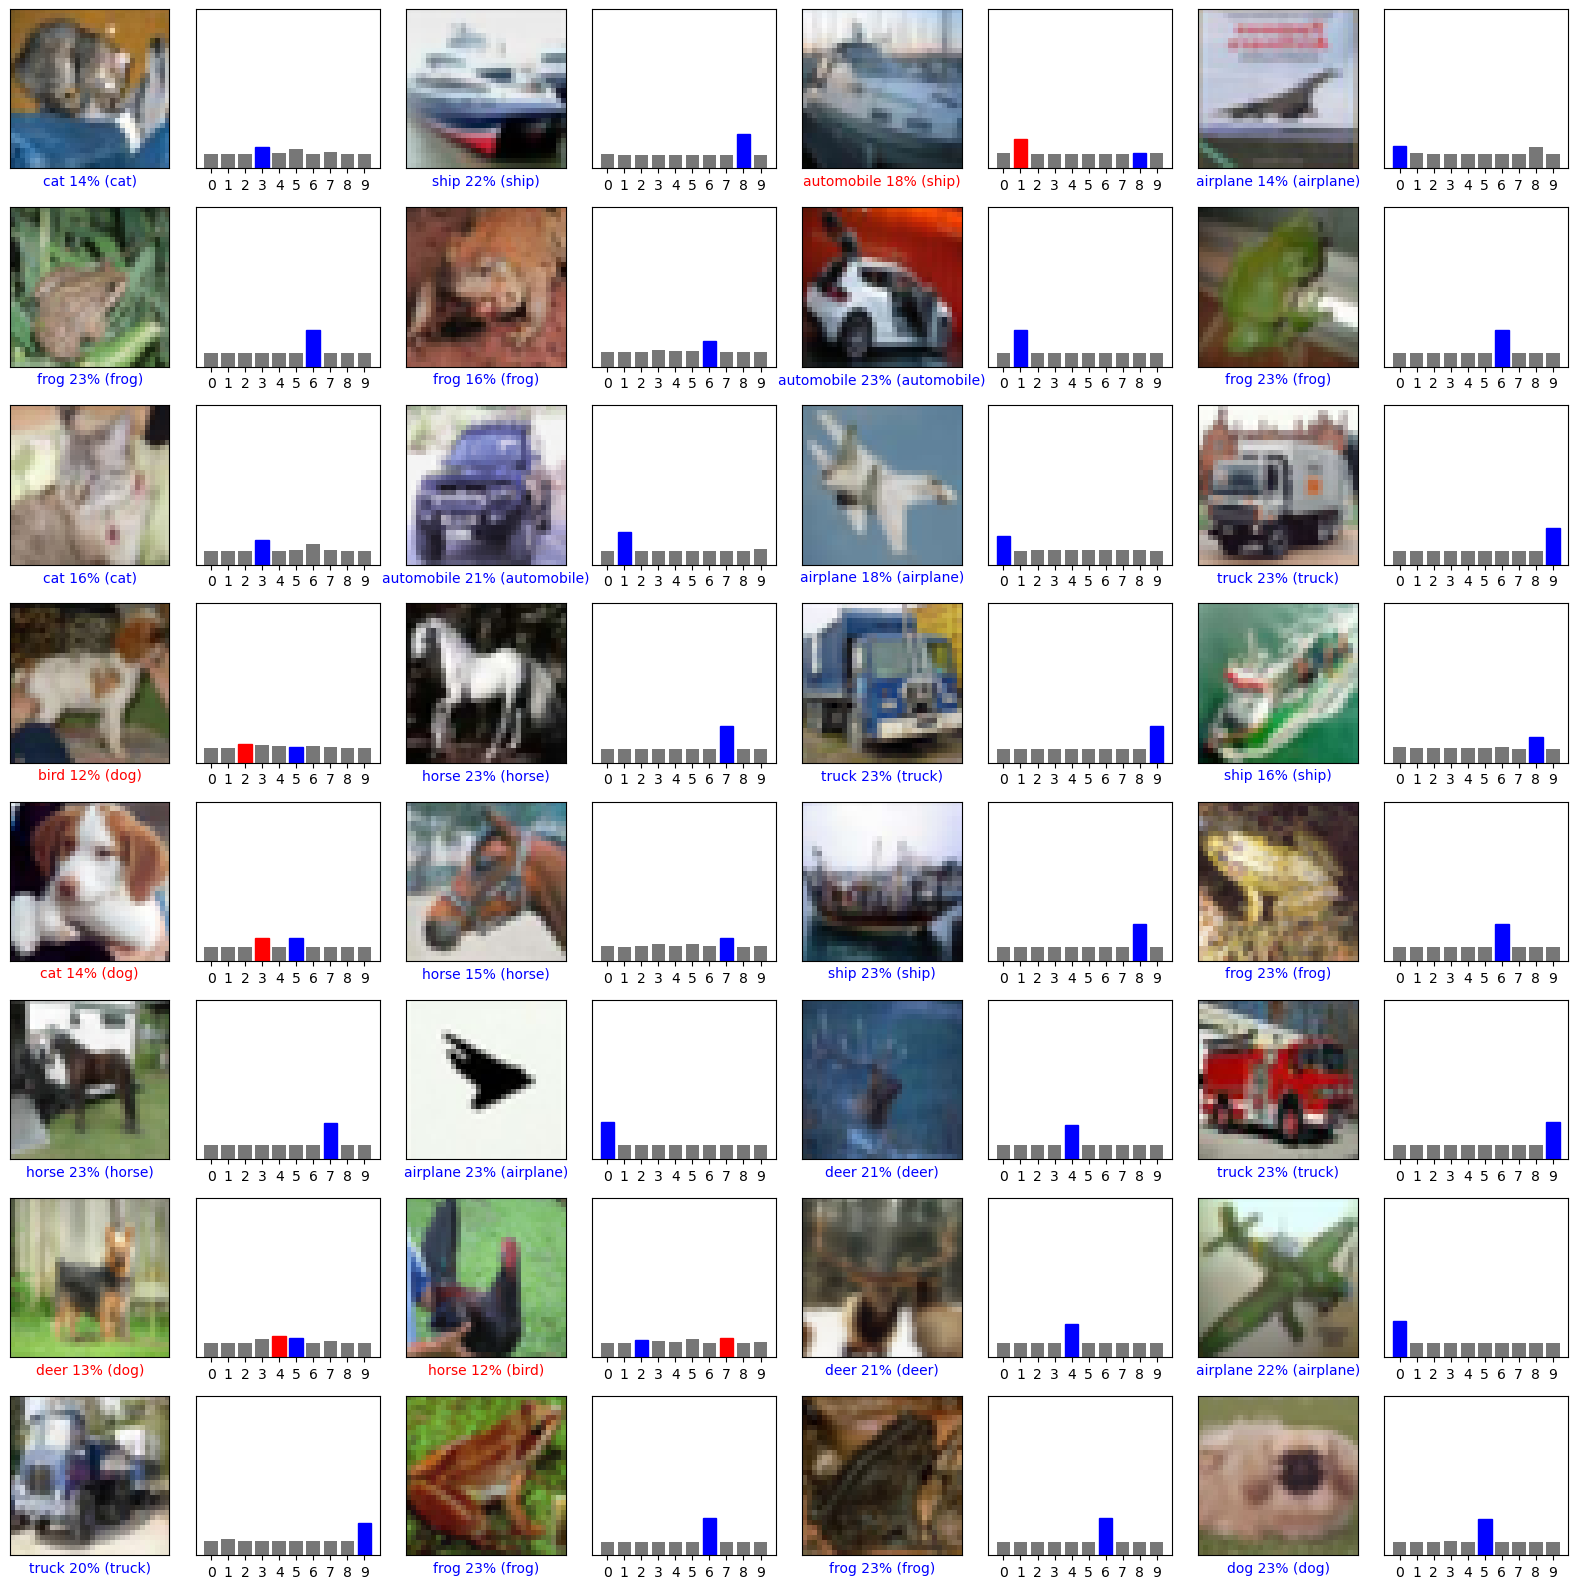

In [58]:
num_rows = 8
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions5best[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions5best[i], test_labels)
plt.tight_layout()
plt.show()

### Results

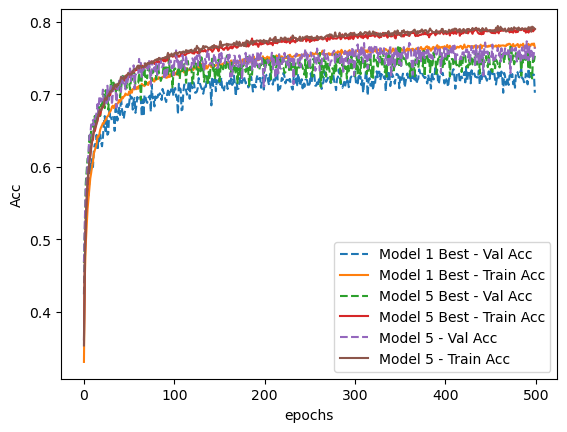

In [153]:
plt.plot(model1best_history.history['val_accuracy'], '--', label="Model 1 Best - Val Acc")
plt.plot(model1best_history.history['accuracy'], label="Model 1 Best - Train Acc")

plt.plot(model5best_history.history['val_accuracy'], '--', label="Model 5 Best - Val Acc")
plt.plot(model5best_history.history['accuracy'], label="Model 5 Best - Train Acc")

plt.plot(model5_history.history['val_accuracy'], '--', label="Model 5 - Val Acc")
plt.plot(model5_history.history['accuracy'], label="Model 5 - Train Acc")

plt.ylabel('Acc')
plt.xlabel('epochs')
plt.legend();

**We can see that this model does not easily overfit, suggesting that the pooling promotes robustness, while the number of epochs can steadily improve performance.**

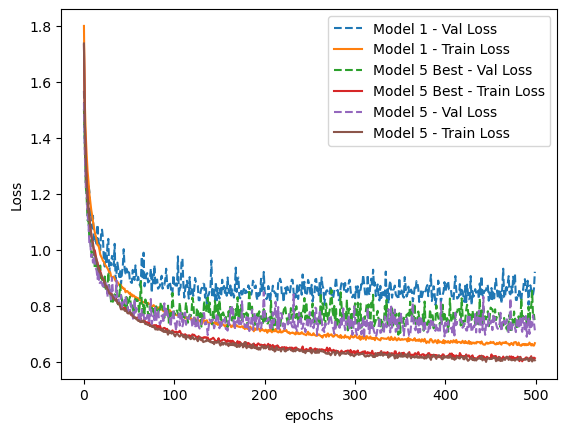

In [154]:
plt.plot(model1best_history.history['val_loss'], '--', label="Model 1 - Val Loss")
plt.plot(model1best_history.history['loss'], label="Model 1 - Train Loss")

plt.plot(model5best_history.history['val_loss'], '--', label="Model 5 Best - Val Loss")
plt.plot(model5best_history.history['loss'], label="Model 5 Best - Train Loss")

plt.plot(model5_history.history['val_loss'], '--', label="Model 5 - Val Loss")
plt.plot(model5_history.history['loss'], label="Model 5 - Train Loss")

plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend();

**Overall, model 5 had the best performance, closely followed by the Best Model callback selection for Model5Best, this suggests that Model 5 was able to learn slightly more over the epochs missed out by its "Best" counterpart. It has been selected for deployment.**

---

## Save the most accurate model with Pickle

In [64]:
import pickle

filename = 'cifarmodel5.sav'
pickle.dump(model5, open(filename, 'wb'))

## Test Model

we will test our models performance against an image, taken from https://www.diesel-plus.com/wp-content/uploads/2019/07/Airplane-Sky-201811-001-720x475.jpg

In [92]:
import cv2
from matplotlib import pyplot as plt

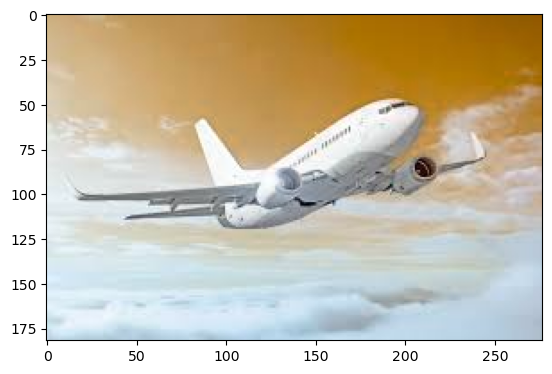

In [143]:
image = cv2.imread('deployment/images.jpg')

plt.imshow(image)
plt.show()

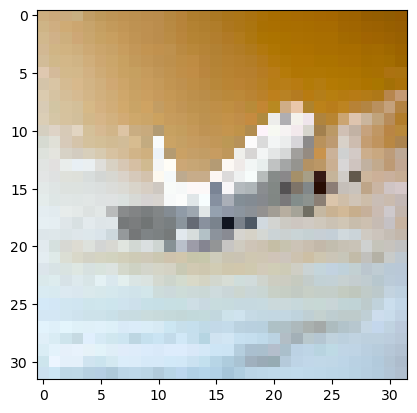

In [144]:
#put data in array format and resize
image = cv2.resize(image, (32,32))
plt.imshow(image)
plt.show()

In [151]:
#normalise the data
data = np.asarray(image)/255.0
print(data.shape)

(32, 32, 3)


In [147]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(data,0))
print(img.shape)

(1, 32, 32, 3)


### Predict the class in order to identify the image

In [148]:
predictions_single = model5.predict(img)

print(predictions_single)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
[[9.5523900e-01 2.2159670e-03 1.9317688e-03 5.0498485e-03 1.9856365e-04
  1.2098049e-02 2.3588079e-03 5.7056081e-03 1.0794755e-03 1.4122862e-02]]


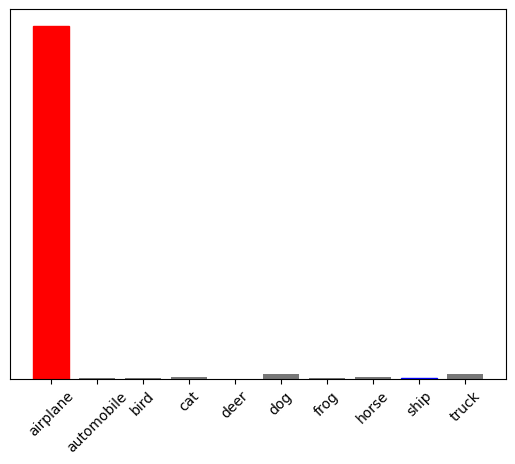

In [149]:
plot_value_array(1, predictions_single[0], test_labels)
_ = plt.xticks(range(10), classnames.values(), rotation=45)
plt.show()